###### preparing input data

import os
import numpy as np
import pandas as pd

os.getcwd()
os.chdir(r'C:\My\x2\180801')
os.getcwd()

file_name = '180801-800~0~800A DATA(UVW상)1.xlsx'
file_name = '180801-800~0~800A DATA(UVW상)3.xlsx'
file_name = '180801-800~0~800A DATA(UVW상)4.xlsx'
file_name = '180801-800~0~800A DATA(UVW상)5.xlsx'
sheet_name = 'Sheet1'

cell_range_list = [('B' + str(5+i*23), 'F' + str(5+i*23+19)) for i in range(17)] + \
[('J' + str(5+i*23), 'N' + str(5+i*23+19)) for i in range(17)]

In [3]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
def load_cells(file_name: str, sheet_name: str, cell_range: tuple):
    from openpyxl import load_workbook
    import pandas as pd

    wb = load_workbook(filename=file_name, read_only=True)
    ws = wb[sheet_name]

    # Read the cell values into a list of lists
    data_rows = []
    for row in ws[cell_range[0]:cell_range[1]]:
        data_cols = []
        for cell in row:
            data_cols.append(cell.value)
        data_rows.append(data_cols)

    # Transform into dataframe
    
    df = pd.DataFrame(data_rows)
    df.columns = ['reg_date', 'G', 'U', 'V', 'W']
    return df

In [5]:
def load_cells_many(file_name: str, sheet_name: str, cell_range_list: list):
    import pandas as pd
    
    df_list = []
    for cell_range in cell_range_list:
        df_list.append(load_cells(file_name, sheet_name, cell_range))
        
    return pd.concat(df_list, ignore_index=True)

# test code

df = load_cells_many(file_name, sheet_name, cell_range_list)
df['Order'] = np.floor(df['G'] * 10)
df = df.sort_values(['Order']).reset_index(drop=True)

###### Tools

In [6]:
from sklearn import metrics
'''
metrics.explained_variance_score
metrics.mean_absolute_error
metrics.mean_squared_error
metrics.mean_squared_log_error
metrics.median_absolute_error
metrics.r2_score
'''

def print_metrics(actual, pred):
    actual = np.array(actual) if isinstance(actual, list) else actual
    pred = np.array(pred) if isinstance(pred, list) else pred

    actual = actual.reshape(-1, 1) if len(actual.shape) == 1 else actual
    pred = pred.reshape(-1, 1) if len(pred.shape) == 1 else pred
    
    evs = metrics.explained_variance_score(actual, pred)
    mse = metrics.mean_squared_error(actual, pred)
    mse_ppm = mse * 1e6 / 800 / 300
    mae = metrics.mean_absolute_error(actual, pred)
    mae_ppm = mae * 1e6 / 800 / 300
    r2 = metrics.r2_score(actual, pred)
    max_abs_err = float(np.max(np.abs(actual - pred)))
    
    print('MSE:     :', mse)
    print('MSE ppm  :', mse_ppm)
    print('MAE:     :', mae)
    print('MAE ppm  :', mae_ppm)
    print('Max er   :', max_abs_err)
    print('EVS:     :', mae)
    print('R2 score :', r2)
    

In [7]:
print_metrics([1, 2, 3], [1.1, 1.9, 3])

MSE:     : 0.006666666666666678
MSE ppm  : 0.02777777777777783
MAE:     : 0.06666666666666672
MAE ppm  : 0.277777777777778
Max er   : 0.10000000000000009
EVS:     : 0.06666666666666672
R2 score : 0.99


### model - poly reg

In [8]:
def get_splitted_data(df, x_label, y_label, is_y_positive=True):
    dataset_X = df[[x_label]]
    y_sign = 1.0 if is_y_positive else -1.0
    dataset_y = ((df[[y_label]] * y_sign / 5 * 1500) / 400) + 2.5
    
    training_set_X, test_set_X, training_set_y, test_set_y = train_test_split(dataset_X,
                                                                              dataset_y,
                                                                              test_size=0.33,
                                                                              random_state=42,
                                                                              shuffle=True)
    return training_set_X, test_set_X, training_set_y, test_set_y

# test code

training_set_X, test_set_X, training_set_y, test_set_y = get_splitted_data(df, x_label='V', y_label='G', is_y_positive=True)

###### plot training set

In [9]:
def plot_training_set(training_set_X, training_set_y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    %matplotlib inline

    plt.style.use('ggplot')
    plt.rcParams["figure.figsize"] = (25,7)
    # plt_x = range(len(training_set_X))
    plt_x = training_set_X.sort_index().index
    plt.plot(plt_x, (training_set_y.sort_index()), label='Xy plot')
    plt.xlabel('X(102)')
    plt.ylabel('y(101)')
    plt.legend()
    plt.show()

# test code

plot_training_set(training_set_X, training_set_y)

###### Ordinary Least Squares

In [10]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

def get_trained_model__poly_reg(training_set_X, training_set_y):
    poly = PolynomialFeatures(degree=10)
    training_set_X_poly_reg = poly.fit_transform(training_set_X)
    model_poly_reg = linear_model.LinearRegression(normalize=True)
    model_poly_reg.fit(training_set_X_poly_reg, training_set_y)
    
    return model_poly_reg, poly

# test code

model, poly = get_trained_model__poly_reg(training_set_X, training_set_y)

In [11]:
def get_prediction(trained_model, poly, test_set_X, do_sort=True):
    if do_sort:
        test_set_X_poly_reg = poly.fit_transform(test_set_X.sort_index())  # sorted by index
    else:
        test_set_X_poly_reg = poly.fit_transform(test_set_X)
        
    test_set_pred_poly_reg = trained_model.predict(test_set_X_poly_reg)
    return test_set_pred_poly_reg

# test code

get_prediction(model, poly, test_set_X, do_sort=True)

In [12]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def plot_error(actual, predicted, is_actual_sorted=True):
    plt.style.use('ggplot')
    plt.rcParams["figure.figsize"] = (25,7)
    plt.ylim(ymax=.005, ymin=-.005)
    # plt_x = range(len(test_set_X))
    plt_x = test_set_X.sort_index().index
    if is_actual_sorted:
        plt.plot(plt_x
                 , (actual.sort_index() - predicted)
                 , label='Xy plot'
                 , linestyle='None'
                 , marker='o')

        plt.xlabel('X(102)')
        plt.ylabel('y(101)')
        plt.legend()
        plt.show()
        print_metrics(actual.sort_index(), predicted)
    else:
        plt.plot(plt_x
                 , (actual - predicted)
                 , label='Xy plot'
                 , linestyle='None'
                 , marker='o')
        plt.xlabel('X(102)')
        plt.ylabel('y(101)')
        plt.legend()
        plt.show()
        print_metrics(actual, predicted)


# test

plot_error(test_set_y, test_set_pred_poly_reg, True)

###### plot - test set

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

'''
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
# plt_x = range(len(training_set_X))
plt_x = test_set_X.sort_index().index
plt.plot(plt_x, (test_set_y.sort_index()), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()


- expected gold error: 1ppm = 800 / 1000000 = 0.0008
- normal silver error: 1% = 800 / 100 = 8

np.min(df['U']), np.max(df['U'])

### grid

# test code

spacing = 0.005

# grid_x_start = 0.5
# grid_x_end = 4.5 + spacing

grid_x_start = 0
grid_x_end = 5

# num_slice = 1000
# grid_x_val, spacing = np.linspace(start=grid_x_start, stop=grid_x_end, num=num_slice, endpoint=True, retstep=True)

grid_x_val = np.arange(start=grid_x_start
                   , stop=grid_x_end
                   , step=spacing)

len(grid_x_val)

grid_x_val_poly_reg = poly.fit_transform(grid_x_val.reshape(-1, 1))
grid_y_val_poly_reg_pred = model_poly_reg.predict(grid_x_val_poly_reg)

In [13]:
def get_bound(grid_x_val, input_x):
    for i in range(len(grid_x_val)-1):
        if grid_x_val[i] <= input_x and input_x <= grid_x_val[i+1]:
            lower = grid_x_val[i]
            upper = grid_x_val[i+1]
            break      
    interval = upper - lower

    # print(lower ,upper, interval)
    
    ip_b = (upper - input_x) / interval
    ip_a = 1 - ip_b
    return i, i+1, ip_a, ip_b

# get_bound(grid_x_val, input_x=3.1211)

In [14]:
def get_bound_fixed_slicing(range_start, range_end, spacing, input_x):
    steps = int((input_x - range_start) / spacing)
    
    lower = steps * spacing
    upper = lower + spacing
    
    interval = spacing
    ip_b = (upper - input_x) / interval
    ip_a = 1 - ip_b
    
    # print(lower, upper, interval)
    
    return steps, steps+1, ip_a, ip_b
    

# get_bound_fixed_slicing(grid_x_start, grid_x_end, spacing, 3.1211)

In [15]:
def grid_inner_pred(input_x, grid_x_val, grid_y):
    
    lower_idx, upper_idx, ip_a, ip_b = get_bound(grid_x_val, input_x)
    lower_y = grid_y[lower_idx]
    upper_y = grid_y[upper_idx]
    
    return lower_y * ip_a + upper_y * ip_b

# test code

grid_inner_pred(3, grid_x_val, grid_y_val_poly_reg_pred)

xy = np.concatenate((grid_x_val.reshape(-1, 1), grid_y_val_poly_reg_pred), axis=1)

from datetime import datetime

d = datetime.now()
out_file_name = file_name + '__n' + str(len(grid_x_val)) + '__d' + d.strftime('%Y%m%d%H%M%S') + '.csv'
np.savetxt(out_file_name, xy, delimiter=",")

###### Here we go

In [44]:
import os
import numpy as np
import pandas as pd

os.getcwd()
os.chdir(r'C:\My\x2\180801')  # change this path
os.getcwd()

file_name = '180801-800~0~800A DATA(UVW상)1.xlsx'
#file_name = '180801-800~0~800A DATA(UVW상)3.xlsx'
#file_name = '180801-800~0~800A DATA(UVW상)4.xlsx'
#file_name = '180801-800~0~800A DATA(UVW상)5.xlsx'
sheet_name = 'Sheet1'

cell_range_list = [('B' + str(5+i*23), 'F' + str(5+i*23+19)) for i in range(17)] + \
[('J' + str(5+i*23), 'N' + str(5+i*23+19)) for i in range(17)]

In [45]:
df = load_cells_many(file_name, sheet_name, cell_range_list)
df['Order'] = np.floor(df['G'] * 10)
df = df.sort_values(['Order']).reset_index(drop=True)

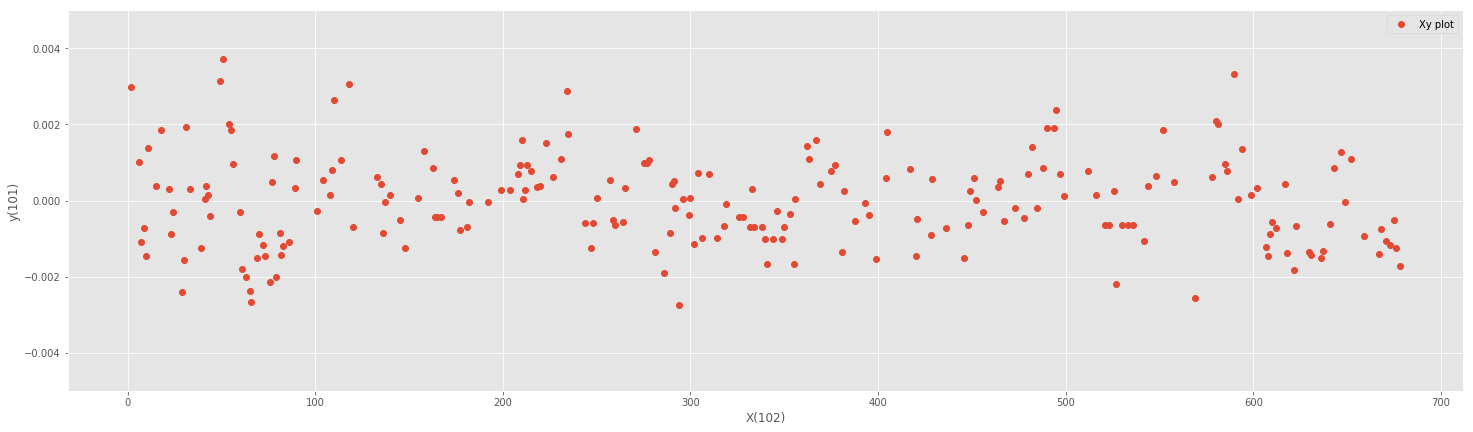

MSE:     : 7.01771893364476e-05
MSE ppm  : 0.0002924049555685317
MAE:     : 0.0015948038450908097
MAE ppm  : 0.006645016021211707
Max er   : 0.12198651498146651
EVS:     : 0.0015948038450908097
R2 score : 0.9999517242084301


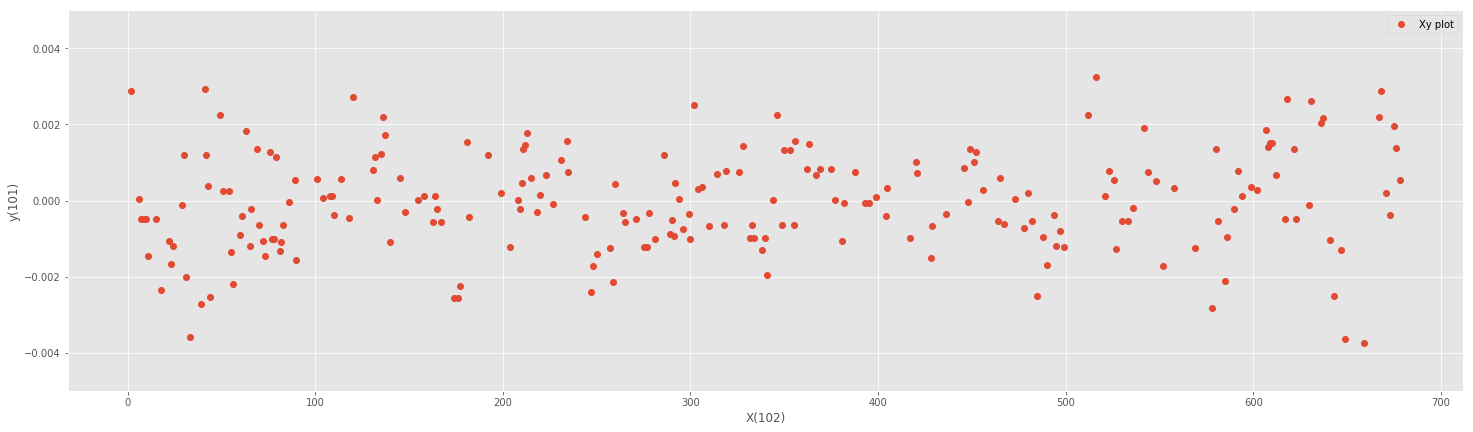

MSE:     : 1.8380682606121156e-06
MSE ppm  : 7.658617752550482e-06
MAE:     : 0.0010547455939869553
MAE ppm  : 0.004394773308278981
Max er   : 0.005431926906085849
EVS:     : 0.0010547455939869553
R2 score : 0.9999987355691916


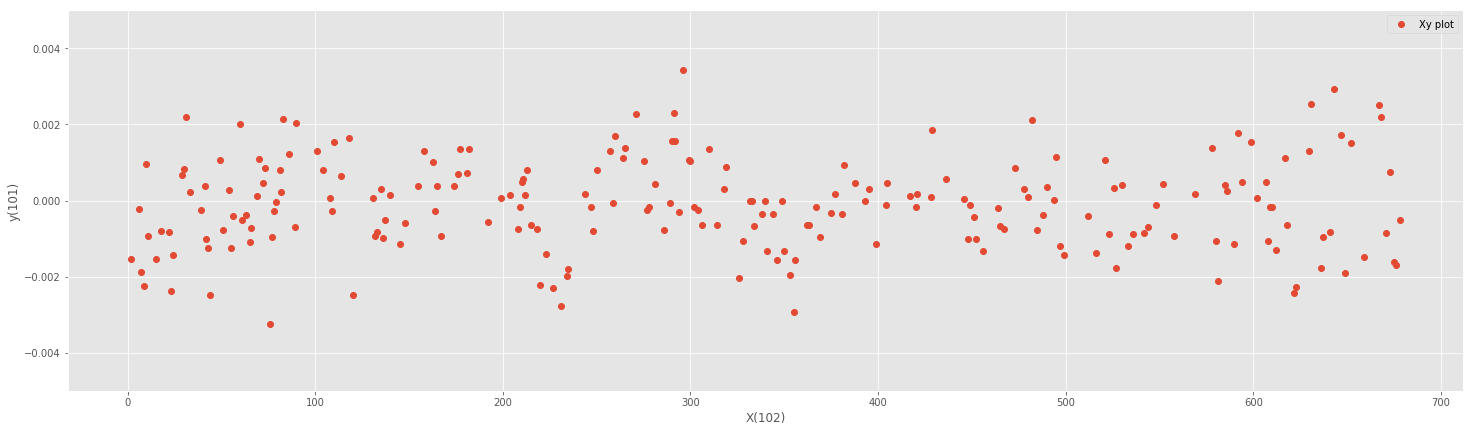

MSE:     : 1.420762807530855e-06
MSE ppm  : 5.919845031378562e-06
MAE:     : 0.0009454840365312379
MAE ppm  : 0.003939516818880158
Max er   : 0.0034230276008124783
EVS:     : 0.0009454840365312379
R2 score : 0.9999990226389827


In [46]:
grid_pred_list = [] 
for x_label, is_y_positive in zip(['U', 'V', 'W'], [False, True, False]):

    training_set_X, test_set_X, training_set_y, test_set_y = get_splitted_data(df,
                                                                               x_label=x_label,
                                                                               y_label='G',
                                                                               is_y_positive=is_y_positive)
    model, poly = get_trained_model__poly_reg(training_set_X, training_set_y)
    pred = get_prediction(model, poly, test_set_X, do_sort=True)
    
    plot_error(test_set_y, pred, True)
    
    # spacing = 0.005
    spacing = 0.00122
    grid_x_start = 0
    grid_x_end = 5

    grid_x_val = np.arange(start=grid_x_start
                       , stop=grid_x_end
                       , step=spacing)

    grid_x_val_poly_reg = poly.fit_transform(grid_x_val.reshape(-1, 1))
    grid_y_val_poly_reg_pred = model.predict(grid_x_val_poly_reg)

    grid_pred_list.append(grid_y_val_poly_reg_pred)

In [47]:
from datetime import datetime


d = datetime.now()
out_file_name = file_name + '__n' + str(len(grid_x_val)) + '__d' + d.strftime('%Y%m%d%H%M%S') + '.xlsx'

xyyy = np.concatenate((grid_x_val.reshape(-1, 1), *grid_pred_list), axis=1)
xyyy_df = pd.DataFrame(xyyy)
xyyy_df.columns = ['x', 'U', 'V', 'W']

writer = pd.ExcelWriter(out_file_name)
xyyy_df.to_excel(writer, 'Sheet1', index=False)
writer.save()